# Vectorized Backtest

In [436]:
import warnings
warnings.filterwarnings('ignore')

In [437]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [438]:
sns.set_style('whitegrid')
np.random.seed(42)

# settings iniciales

In [439]:
#periodo target. 1 implica que queremos predecir 1 periodo siguiente. (una semana en caso de datos semanales)
periodo_target=1 

## Load Data

### Return Predictions

In [440]:
# Lee el archivo hdf
store = pd.HDFStore('data/predictions.h5')

# Obtiene las claves
keys = store.keys()

# Cierra el archivo hdf
store.close()

# Imprime las claves
print(keys)

['/lgb/train/01', '/lgb/test/01']


In [441]:
#tomamos los resultados de las 10 mejores configuraciones de los predictores
predictions = pd.concat([pd.read_hdf('data/predictions.h5', 'lgb/train/01'),
                        pd.read_hdf('data/predictions.h5', 'lgb/test/01').drop('y_test', axis=1)])

N_BEST_MODELS = 2#10
#tomamos la media
predictions = (predictions.loc[~predictions.index.duplicated()]#si se duplican indices tomara los del train, ose los primeros
                   .iloc[:, :N_BEST_MODELS]
                   .mean(1)
                   .sort_index()
                   .dropna()
                  .to_frame('prediction'))
tickers = predictions.index.get_level_values('ticker').unique().tolist()#modificado ticker por symbol


In [442]:
datos_train=(pd.read_hdf('data/predictions.h5', 'lgb/train/01'))
datos_test=pd.read_hdf('data/predictions.h5', 'lgb/test/01')

In [443]:
#fin del train
datos_train.sort_index().loc['XLY'].tail(1)

,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,
2019-12-29,0.085536,0.0829,0.068404,0.036571,0.098718,0.06973,0.082578,0.07263,0.068404,0.083778


In [444]:
#comienzo del test
datos_test.sort_index().loc['XLY'].head(1)

,y_test,0,1,2,3,4,5,6,7,8,9
date,,,,,,,,,,,
2020-02-09,1.531074,0.091406,0.089419,0.084028,0.159994,0.059273,0.086813,0.081831,0.055612,0.084028,0.090506


In [445]:
#prueba = (pd.read_hdf('../12_gradient_boosting_machines/data/predictions.h5', 'lgb/train/01')
#                   .append(pd.read_hdf('../12_gradient_boosting_machines/data/predictions.h5', 'lgb/test/01').drop('y_test', axis=1)))

In [446]:
#prueba.sort_index().loc['XLY.US'].loc['2015'].tail(4)

In [447]:
datos_test.loc['XLY'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 254 entries, 2024-12-15 to 2020-02-09
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y_test  254 non-null    float64
 1   0       254 non-null    float64
 2   1       254 non-null    float64
 3   2       254 non-null    float64
 4   3       254 non-null    float64
 5   4       254 non-null    float64
 6   5       254 non-null    float64
 7   6       254 non-null    float64
 8   7       254 non-null    float64
 9   8       254 non-null    float64
 10  9       254 non-null    float64
dtypes: float64(11)
memory usage: 23.8 KB


In [448]:
predictions

prediction
ticker date                  
IYR    2011-01-16    0.115722
       2011-01-23    0.043051
       2011-01-30    0.036567
       2011-02-06    0.038468
       2011-02-13    0.044756
...                       ...
XLY    2024-11-17    0.064991
       2024-11-24    0.054476
       2024-12-01    0.089452
       2024-12-08    0.083079
       2024-12-15    0.080300

[7942 rows x 1 columns]

In [449]:
predictions.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 7942 entries, ('IYR', Timestamp('2011-01-16 00:00:00')) to ('XLY', Timestamp('2024-12-15 00:00:00'))
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  7942 non-null   float64
dtypes: float64(1)
memory usage: 128.2+ KB


In [450]:
# assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)

predicciones=(predictions
            .unstack('ticker')
            .prediction)


In [451]:
predicciones

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2011-01-16,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722
2011-01-23,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051
2011-01-30,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567
2011-02-06,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468
2011-02-13,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-17,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991
2024-11-24,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476
2024-12-01,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452


In [452]:
predicciones.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 722 entries, 2011-01-16 to 2024-12-15
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   IYR     722 non-null    float64
 1   VOX     722 non-null    float64
 2   XLB     722 non-null    float64
 3   XLE     722 non-null    float64
 4   XLF     722 non-null    float64
 5   XLI     722 non-null    float64
 6   XLK     722 non-null    float64
 7   XLP     722 non-null    float64
 8   XLU     722 non-null    float64
 9   XLV     722 non-null    float64
 10  XLY     722 non-null    float64
dtypes: float64(11)
memory usage: 67.7 KB


### SP500 Benchmark

In [453]:
#sp500 = web.DataReader('SP500', 'fred', '2014', '2018').pct_change()

In [454]:
#sp500.info()

## Compute Forward Returns

In [455]:
#tomamos los datos

In [456]:
DATA_STORE = 'data/assets.h5'

In [457]:
idx = pd.IndexSlice

In [458]:
with pd.HDFStore(DATA_STORE) as store:
    print(store.keys())
    data = (store['data_raw']
            .sort_index()
            .loc[idx[:, :'2024'], :])

['/data_close', '/data_raw', '/engineered_features', '/engineered_features_pca', '/engineered_features_pca_10_trimmed', '/engineered_features_pca_95_trimmed', '/engineered_features_pca_trimmed', '/engineered_features_trimmed']


In [459]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 13750 entries, ('IYR', Timestamp('2001-01-07 00:00:00')) to ('XLY', Timestamp('2024-12-15 00:00:00'))
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   return_1w   13750 non-null  float64
 1   return_2w   13750 non-null  float64
 2   return_3w   13750 non-null  float64
 3   return_6w   13750 non-null  float64
 4   return_12w  13750 non-null  float64
 5   return_52w  13750 non-null  float64
dtypes: float64(6)
memory usage: 727.7+ KB


In [460]:
#localizamos target_1m para las fechas y tickers de predictions
fwd_returns = (data.loc[idx[predictions.index.get_level_values('ticker').unique(),
               predictions.index.get_level_values('date').unique()],:]
               .sort_index(ascending=False))

In [461]:
fwd_returns

return_1w  return_2w  return_3w  return_6w  return_12w  \
ticker date                                                                 
XLY    2024-12-15   0.007560   0.027205   0.024549   0.026845    0.014782   
       2024-12-08   0.047233   0.033151   0.029364   0.024943    0.015975   
       2024-12-01   0.019257   0.020544   0.011004   0.018191    0.016622   
       2024-11-24   0.021833   0.006903   0.029145   0.017465    0.012849   
       2024-11-17  -0.007810   0.032821   0.020540   0.012449    0.010691   
...                      ...        ...        ...        ...         ...   
IYR    2011-02-13   0.025925   0.017995   0.017497   0.009879    0.008339   
       2011-02-06   0.010126   0.013310   0.008555   0.008332    0.004294   
       2011-01-30   0.016504   0.007771   0.009186   0.009223   -0.000493   
       2011-01-23  -0.000887   0.005547   0.002318   0.005057    0.002084   
       2011-01-16   0.012022   0.003924   0.008108   0.003228    0.000534   

                   return_52w  
ticker date                    
XLY    2024-12-15    0.005189  
       2024-12-08    0.005704  
       2024-12-01    0.005048  
       2024-11-24    0.005004  
       2024-11-17    0.004713  
...                       ...  
IYR    2011-02-13    0.006112  
       2011-02-06    0.005470  
       2011-01-30    0.005337  
       2011-01-23    0.004857  
       2011-01-16    0.004050  

[7942 rows x 6 columns]

In [462]:
#daily_returns = data.open.unstack('ticker').sort_index().pct_change()
#daily_returns.info()

# Definimos period target

In [463]:
#creamos la variable target_{lookahead} mesesm
fwd_returns[f'target_{periodo_target}m'] = data.groupby(level='ticker')[f'return_{periodo_target}w'].shift(-periodo_target)

In [464]:
#se hace la asignación del retorno de un perdio fwd

fwd_returns = fwd_returns[f'target_{periodo_target}m'].unstack('ticker').sort_index()

In [465]:
#eliminamos SPY
#fwd_returns.drop('SPY.US', axis=1, inplace=True)
fwd_returns.head()

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2011-01-16,-0.000887,-0.018470,-0.034021,-0.007785,-0.015550,-0.000278,-0.017195,0.005455,0.006616,0.000311,-0.002637
2011-01-23,0.016504,0.002022,0.008805,0.014408,-0.012758,-0.001950,0.004277,-0.017294,-0.009390,-0.018018,-0.019038
2011-01-30,0.010126,0.022350,0.046813,0.042469,0.022154,0.026514,0.033295,0.011042,0.004739,0.022778,0.029919
2011-02-06,0.025925,0.022013,0.006822,-0.000270,0.028296,0.029092,0.007868,0.009556,0.006289,0.001547,0.035855
2011-02-13,0.004549,-0.009804,0.010038,0.039266,0.005855,0.005020,0.003717,0.007437,-0.002813,0.013280,0.010864


In [466]:

media = fwd_returns.mean(axis=1).shift(1)
media.name = 'mediasec'

## Generate Signals

In [467]:
#predictions = data.predicted.unstack('ticker')
#predictions.info()

In [468]:
#eliminamos SPY si comparamos con benchmark
#predicciones.drop('SPY.US', axis=1, inplace=True)
predicciones

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2011-01-16,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722
2011-01-23,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051
2011-01-30,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567
2011-02-06,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468
2011-02-13,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-17,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991
2024-11-24,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476
2024-12-01,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452


In [469]:
N_LONG = N_SHORT = 3

In [470]:
long_signals = ((predicciones
                .where(predicciones > 0)
                .rank(axis=1, ascending=False, method='first') <= N_LONG)
                .astype(int))
short_signals = ((predicciones
                  .where(predicciones < 0)
                  .rank(axis=1, method='first') <= N_SHORT)
                 .astype(int))

## Compute Portfolio Returns

Calculamos pesos según la predicción

In [471]:
# Multiply long signals by predictions and normalize each row to sum to 1
weights_long = (long_signals.mul(predicciones)
 .div(long_signals.mul(predicciones).sum(axis=1), axis=0)
 .fillna(0))

weights_short = (short_signals.mul(predicciones)
 .div(short_signals.mul(predicciones).sum(axis=1), axis=0)
 .fillna(0))


In [472]:
long_returns = long_signals.mul(fwd_returns).replace(0, np.nan).mean(axis=1).fillna(0)
short_returns = short_signals.mul(-fwd_returns).replace(0, np.nan).mean(axis=1).fillna(0)
strategy = long_returns.add(short_returns).to_frame('Strategy')

In [473]:
long_returns

date
2011-01-16   -0.017793
2011-01-23    0.009110
2011-01-30    0.026430
2011-02-06    0.018253
2011-02-13    0.001594
                ...   
2024-11-17    0.023826
2024-11-24    0.014367
2024-12-01   -0.006563
2024-12-08   -0.008457
2024-12-15    0.000000
Length: 722, dtype: float64

In [474]:
strategy

,Strategy
date,
2011-01-16,-0.017793
2011-01-23,0.009110
2011-01-30,0.026430
2011-02-06,0.018253
2011-02-13,0.001594
...,...
2024-11-17,0.023826
2024-11-24,0.014367
2024-12-01,-0.006563


<Axes: ylabel='Frequency'>

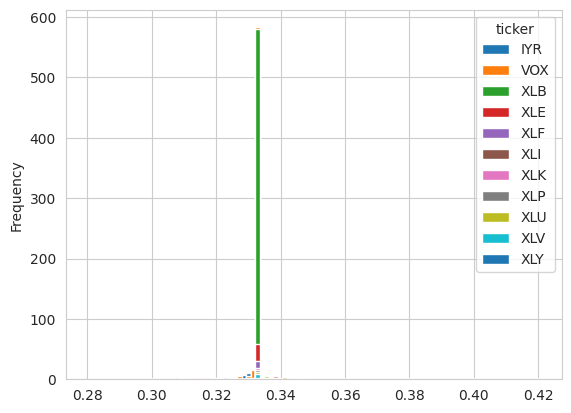

In [475]:
weights_long.replace(0, np.nan).plot.hist(bins = 100, )


In [476]:
long_signals.sum()

ticker
IYR    656
VOX    649
XLB    598
XLE     81
XLF     40
XLI     20
XLK     27
XLP     24
XLU     35
XLV     20
XLY     10
dtype: int64

In [477]:
weights_long

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2011-01-16,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-23,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-01-30,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-06,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2011-02-13,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-17,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-11-24,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2024-12-01,0.333333,0.333333,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [478]:
long_weighted_returns = weights_long.mul(fwd_returns).replace(0, np.nan).sum(axis=1).fillna(0)
short_weighted_returns = weights_short.mul(-fwd_returns).replace(0, np.nan).sum(axis=1).fillna(0)
strategy_weighted = long_weighted_returns.add(short_weighted_returns).to_frame('Strategy Weighted')
strategy_weighted

,Strategy Weighted
date,
2011-01-16,-0.017793
2011-01-23,0.009110
2011-01-30,0.026430
2011-02-06,0.018253
2011-02-13,0.001594
...,...
2024-11-17,0.023826
2024-11-24,0.014367
2024-12-01,-0.006563


In [479]:
short_signals.loc['2019':].describe()

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
count,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0,306.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [480]:
long_signals.loc['2019':].describe()

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
count,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000,306.000000
mean,0.905229,0.895425,0.807190,0.133987,0.068627,0.022876,0.042484,0.026144,0.039216,0.032680,0.026144
std,0.293378,0.306506,0.395152,0.341196,0.253234,0.149752,0.202020,0.159824,0.194426,0.178088,0.159824
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [481]:
long_signals.loc['2019':].sum()

ticker
IYR    277
VOX    274
XLB    247
XLE     41
XLF     21
XLI      7
XLK     13
XLP      8
XLU     12
XLV     10
XLY      8
dtype: int64

In [482]:
long_signals.sum().sum()

2160

In [483]:
predicciones

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2011-01-16,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722,0.115722
2011-01-23,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051,0.043051
2011-01-30,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567,0.036567
2011-02-06,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468,0.038468
2011-02-13,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756,0.044756
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-17,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991,0.064991
2024-11-24,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476,0.054476
2024-12-01,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452,0.089452


In [484]:
short_signals

ticker,IYR,VOX,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
date,,,,,,,,,,,
2011-01-16,0,0,0,0,0,0,0,0,0,0,0
2011-01-23,0,0,0,0,0,0,0,0,0,0,0
2011-01-30,0,0,0,0,0,0,0,0,0,0,0
2011-02-06,0,0,0,0,0,0,0,0,0,0,0
2011-02-13,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-11-17,0,0,0,0,0,0,0,0,0,0,0
2024-11-24,0,0,0,0,0,0,0,0,0,0,0
2024-12-01,0,0,0,0,0,0,0,0,0,0,0


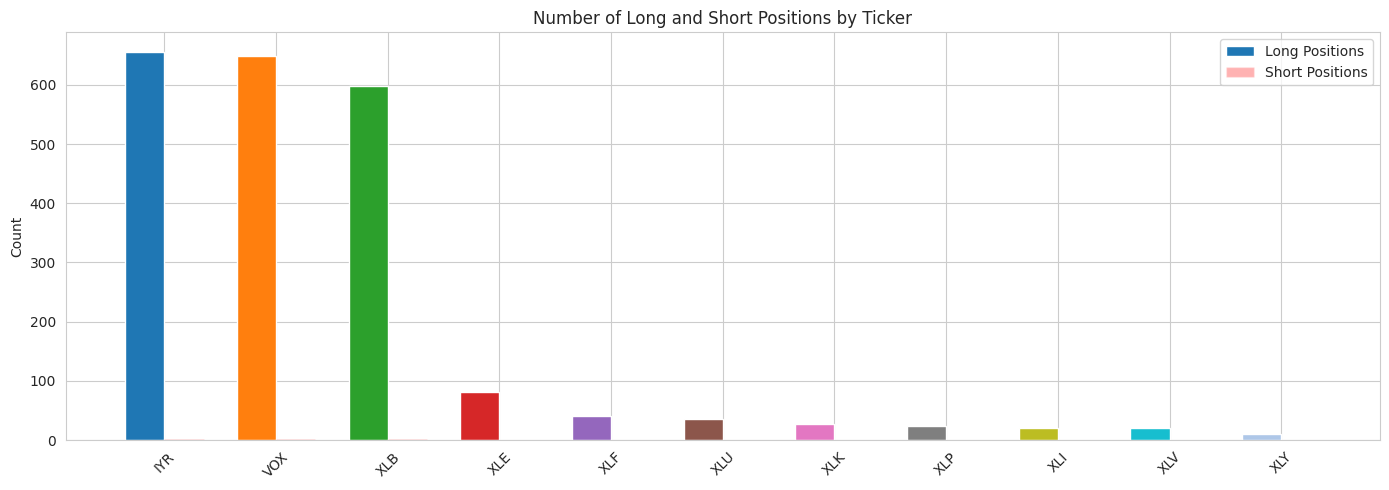

In [485]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#aec7e8']
fig, ax = plt.subplots(figsize=(14,5))

# Ordenar los datos de mayor a menor según los longs
long_sums = long_signals.sum().sort_values(ascending=False)
short_sums = short_signals[long_sums.index].sum()

# Crear un índice para las posiciones de las barras
x = np.arange(len(long_sums))
width = 0.35  # Ancho de las barras

# Graficar barras largas y cortas una al lado de la otra
ax.bar(x - width/2, long_sums, width, color=colors, label='Long Positions')
ax.bar(x + width/2, short_sums, width, color='red', alpha=0.3, label='Short Positions')

plt.title('Number of Long and Short Positions by Ticker')
plt.ylabel('Count')
plt.xticks(x, long_sums.index, rotation=45)
plt.legend()
plt.tight_layout()


## Plot results

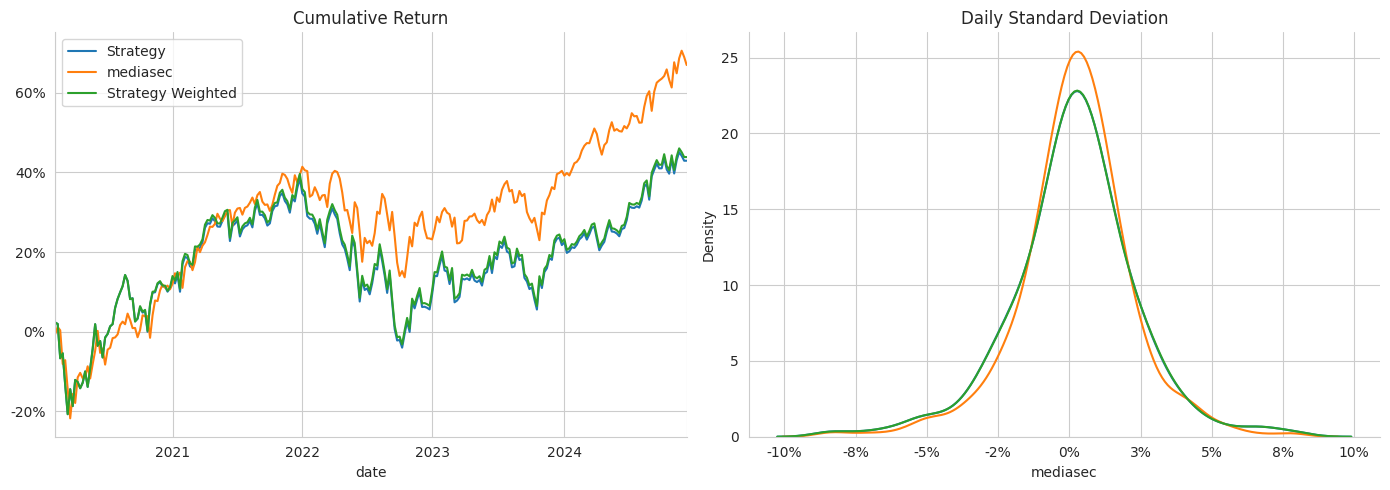

In [486]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy.loc['2020':].join(media).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
#strategy.join(sp500).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
strategy_weighted.loc['2020':].add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(media, ax=axes[1], hist=False, label='media')
sns.distplot(strategy_weighted.dropna(), ax=axes[1], hist=False, label='Strategy Weighted')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

sns.despine()
fig.tight_layout();

In [487]:
res = strategy.join(media).dropna()

In [488]:
res.std()

Strategy    0.022322
mediasec    0.019989
dtype: float64

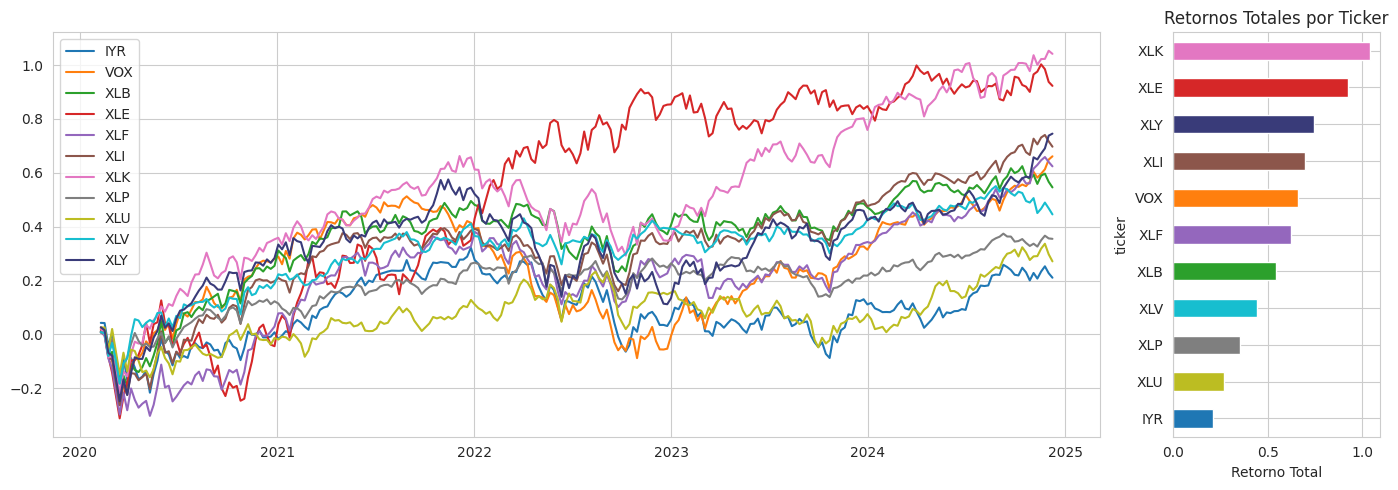

In [489]:
# fwd_returns.loc['2020':].cumsum().plot(figsize=(14,5))
# Crear figura con dos subplots
# plt.figure(figsize=(14,5))

# Subplot izquierdo - gráfico de retornos acumulados
# plt.subplot(121)
# Crear figura con GridSpec para controlar el ancho relativo de los subplots
fig = plt.figure(figsize=(14,5))
gs = fig.add_gridspec(1, 5)  # 5 columnas en total
ax1 = fig.add_subplot(gs[0, :4])  # Primer subplot ocupa 4 columnas
ax2 = fig.add_subplot(gs[0, 4])   # Segundo subplot ocupa 1 columna

# Definir colores para cada ticker
colors = {'IYR': '#1f77b4', 'VOX': '#ff7f0e', 'XLB': '#2ca02c', 
          'XLE': '#d62728', 'XLF': '#9467bd', 'XLI': '#8c564b',
          'XLK': '#e377c2', 'XLP': '#7f7f7f', 'XLU': '#bcbd22', 
          'XLV': '#17becf', 'XLY': '#393b79'}

# Gráfico de retornos acumulados con colores personalizados
for ticker in fwd_returns.columns:
    data = fwd_returns.loc['2020':, ticker].cumsum()
    ax1.plot(data.index, data.values, label=ticker, color=colors[ticker])
ax1.legend()

# Gráfico de barras horizontales con los mismos colores
returns_by_ticker = fwd_returns.loc['2020':].sum().sort_values()
returns_by_ticker.plot(kind='barh', ax=ax2, 
                      color=[colors[x] for x in returns_by_ticker.index])

ax2.set_title('Retornos Totales por Ticker')
ax2.set_xlabel('Retorno Total')
plt.tight_layout()


solo largos

In [490]:
#sólo largos
strategy_long = long_returns.to_frame('Strategy')
strategy_long_weighted = long_weighted_returns.to_frame('Strategy Weighted')

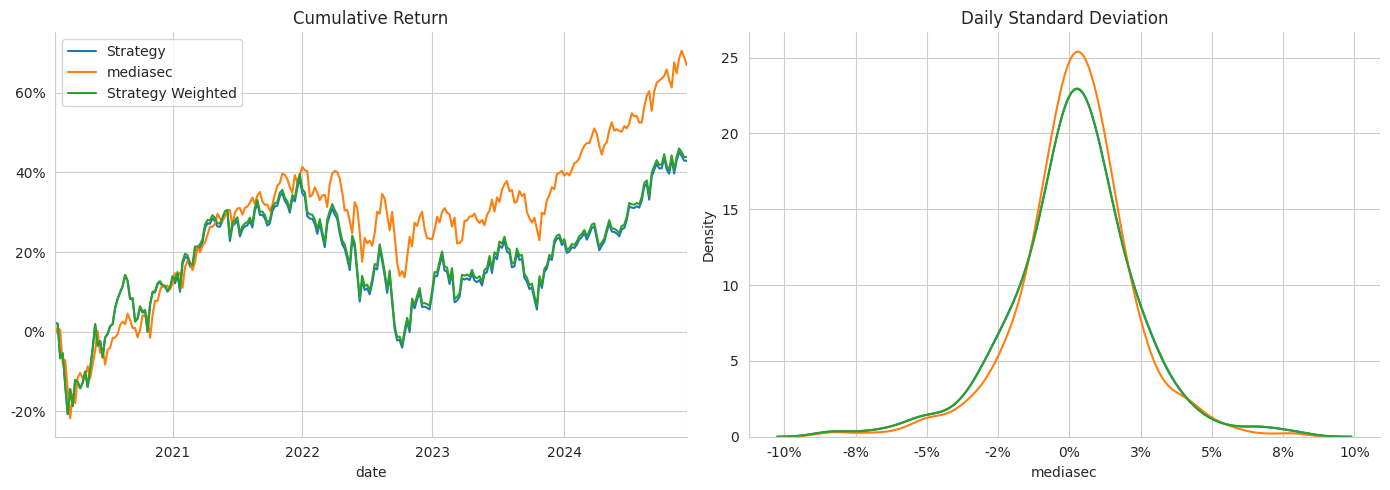

In [491]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy_long.loc['2020':].join(media).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
strategy_long_weighted.loc['2020':].add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy_long.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(media, ax=axes[1], hist=False, label='media')
sns.distplot(strategy_long_weighted.dropna(), ax=axes[1], hist=False, label='Strategy Weighted')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

sns.despine()
fig.tight_layout();

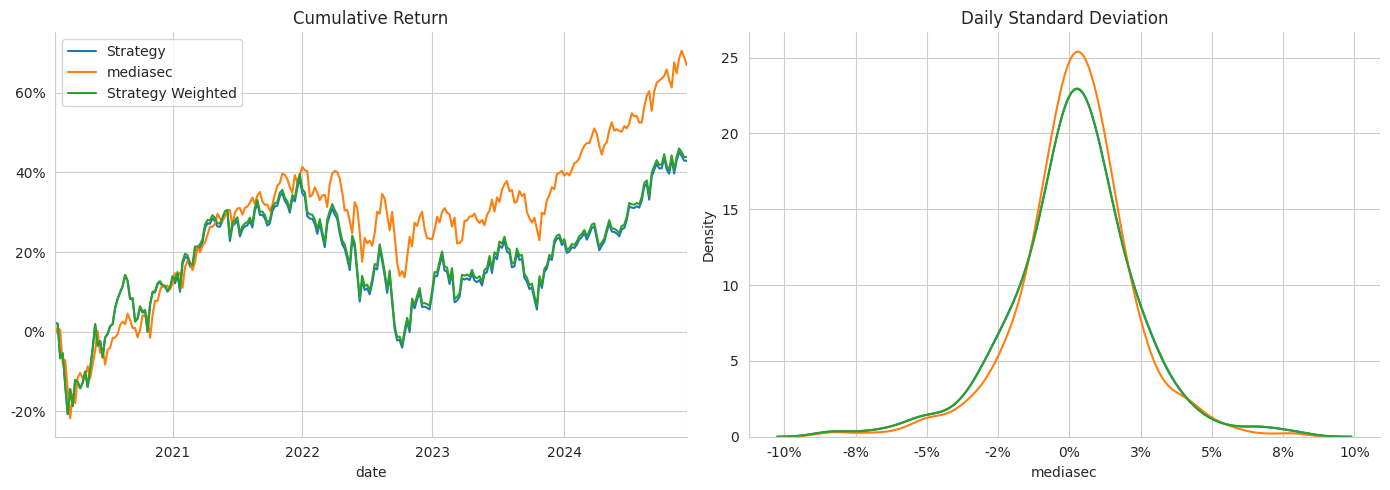

In [492]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy_long.loc['2020':].join(media).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
strategy_long_weighted.loc['2020':].add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy_long.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(media, ax=axes[1], hist=False, label='media')
sns.distplot(strategy_long_weighted.dropna(), ax=axes[1], hist=False, label='Strategy Weighted')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

sns.despine()
fig.tight_layout();

In [493]:
print("Fecha mínima:", strategy_long.index.min())
print("Fecha máxima:", strategy_long.index.max())

Fecha mínima: 2011-01-16 00:00:00
Fecha máxima: 2024-12-15 00:00:00


solo cortos

In [494]:
#sólo CORTOS
strategy_short = short_returns.to_frame('Strategy')
strategy_short_weighted = short_weighted_returns.to_frame('Strategy Weighted')

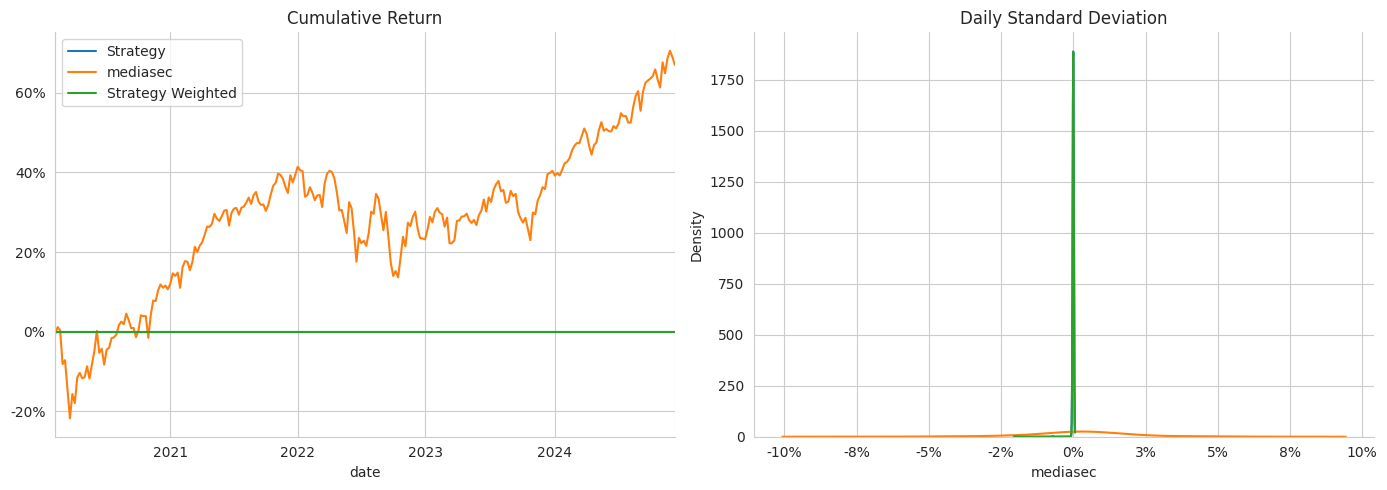

In [495]:
fig, axes = plt.subplots(ncols=2, figsize=(14,5))
strategy_short.loc['2020':].join(media).add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
strategy_short_weighted.loc['2020':].add(1).cumprod().sub(1).plot(ax=axes[0], title='Cumulative Return')
sns.distplot(strategy_short.dropna(), ax=axes[1], hist=False, label='Strategy')
sns.distplot(media, ax=axes[1], hist=False, label='media')
sns.distplot(strategy_short_weighted.dropna(), ax=axes[1], hist=False, label='Strategy Weighted')
axes[1].set_title('Daily Standard Deviation')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[1].xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
fig.tight_layout();